# **Data Processing**

The data and necessary modules are loaded into the python environment, and the data is batched.

In [49]:
# importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import time
import matplotlib.pyplot as plot

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/assign2_train')
val_dataset = tf.data.Dataset.load('/content/drive/MyDrive/assign2_val')

In [52]:
# Batch training data
batch_size = 128

train_dataset_batch = train_dataset.batch(batch_size)

In [53]:
# Batch validation data
batch_size = 128

val_dataset_batch = val_dataset.batch(batch_size)

# **P1.1**


The CNN based classifier with two parallel branches is created as below (and as specified). The 'softmax' activation function is used in the dense output layer to assign probability values to each potential classification genre, and thus the output size of the model is 8 (as there are 8 genres). The categorical cross entropy function is used to measure loss since this is a multi-class classification problem. Accuracy is used as the evaluation metric for the model. 

In [79]:
# Specify input shape and create input layer 
input = tf.keras.layers.Input(shape= (80, 80, 1))

# Parallel branch one - one convolutional layer, one pooling layer and one flattening layer
cnn1 = tf.keras.layers.Conv2D(filters = 3, kernel_size = (8,8), padding='same')(input)
cnn1 = tf.keras.layers.LeakyReLU(alpha=0.3)(cnn1)
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))(cnn1)
flat1 = tf.keras.layers.Flatten()(maxpool1)

# Parallel branch two - one convolutional layer, one pooling layer and one flattening layer
cnn2 = tf.keras.layers.Conv2D(filters = 4, kernel_size = (4,4), padding='same')(input)
cnn2 = tf.keras.layers.LeakyReLU(alpha=0.3)(cnn2)
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn2)
flat2 = tf.keras.layers.Flatten()(maxpool2)

# Combine two branches
total = tf.keras.layers.concatenate([flat1, flat2])

# Final output layer
output = tf.keras.layers.Dense(8, activation='softmax')(total)

# Create model
model = tf.keras.Model(inputs=input, outputs=output)

The model is compiled using a mini-batch stochastic gradient descent algorithm, and is trained for 50 epochs.

In [80]:
# Construct SGD optimiser with learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
# Number of epochs is set to 50, and the pre-batched dataset is passed into the model to implement mini-batch SGD
no_epochs = 50
history = model.fit(train_dataset_batch, epochs=no_epochs, validation_data=(val_dataset_batch))


Epoch 1/50
75/75 [==============================] - 2s 16ms/step - loss: 1.3015 - accuracy: 0.5261 - val_loss: 1.0175 - val_accuracy: 0.6242
Epoch 2/50
75/75 [==============================] - 1s 15ms/step - loss: 0.8242 - accuracy: 0.7013 - val_loss: 0.8457 - val_accuracy: 0.6850
Epoch 3/50
75/75 [==============================] - 1s 18ms/step - loss: 0.6529 - accuracy: 0.7636 - val_loss: 0.8045 - val_accuracy: 0.7096
Epoch 4/50
75/75 [==============================] - 2s 20ms/step - loss: 0.5451 - accuracy: 0.8077 - val_loss: 0.8472 - val_accuracy: 0.7088
Epoch 5/50
75/75 [==============================] - 1s 16ms/step - loss: 0.4668 - accuracy: 0.8345 - val_loss: 0.9132 - val_accuracy: 0.6913
Epoch 6/50
75/75 [==============================] - 1s 15ms/step - loss: 0.4196 - accuracy: 0.8523 - val_loss: 0.9264 - val_accuracy: 0.7000
Epoch 7/50
75/75 [==============================] - 1s 15ms/step - loss: 0.3666 - accuracy: 0.8725 - val_loss: 0.9478 - val_accuracy: 0.7004
Epoch 8/50
75

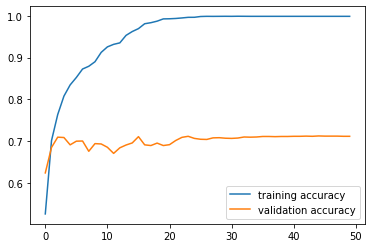

In [82]:
# Plot accuracy values for training and validation sets
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

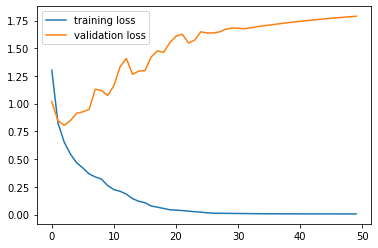

In [83]:
# Plot loss values for training and validation sets
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

After 50 training epochs, an accuracy of approximately 71% is achieved on the validation set. However, one can see that the training accuracy and validation accuracy are very far apart and do not converge together. In fact, the validation loss is seen to increase over epochs, whilst the training loss converges to zero. Clearly, there is much room for improvement in this model.

# **P1.2**

Firstly, the dimension of the data is reduced using the reduce_dimension function.

In [84]:
def reduce_dimension(x, y):

  return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

The data is then pre-batched into sizes of 128 as before.

In [85]:
batch_size = 128

train_dataset_squeeze_batch = train_dataset_squeeze.batch(batch_size)
val_dataset_squeeze_batch = val_dataset_squeeze.batch(batch_size)

The data is now of shape (80,80), compared to it's initial (80, 80, 1) shape. The CNN-RNN architecture is created.

In [89]:
# Input layer is initialised
input = tf.keras.layers.Input(shape=(80, 80))

# Convolutional layer 1
cnn1 = tf.keras.layers.Conv1D(filters=8, kernel_size=4)(input)

# MaxPool layer
maxpool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn1)

# Convolutional layer 2
cnn2 = tf.keras.layers.Conv1D(filters=6, kernel_size=3, activation='relu')(maxpool1)

# MaxPool layer
maxpool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn2)

# LSTM layers
lstm1 = tf.keras.layers.LSTM(units=128, return_sequences=True)(maxpool2)
lstm2 = tf.keras.layers.LSTM(units=32)(lstm1)

# Dense layer 
dense = tf.keras.layers.Dense(200, activation='relu')(lstm2)

# Dropout layer
drop = tf.keras.layers.Dropout(0.2)(dense)

# Dense output layer
output = tf.keras.layers.Dense(units=8, activation='softmax')(drop)

# Create model
model = tf.keras.Model(inputs=input, outputs=output)

Accuracy and categorical cross entropy are again utilised as the evaluation metric and loss function.

In [90]:
# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
# Train the model
history = model.fit(train_dataset_squeeze_batch, validation_data=(val_dataset_squeeze_batch), epochs=50)

Epoch 1/50
75/75 [==============================] - 7s 49ms/step - loss: 1.9812 - accuracy: 0.2249 - val_loss: 1.8933 - val_accuracy: 0.2488
Epoch 2/50
75/75 [==============================] - 2s 22ms/step - loss: 1.8304 - accuracy: 0.2877 - val_loss: 1.8052 - val_accuracy: 0.3008
Epoch 3/50
75/75 [==============================] - 2s 29ms/step - loss: 1.7616 - accuracy: 0.3222 - val_loss: 1.7639 - val_accuracy: 0.3217
Epoch 4/50
75/75 [==============================] - 2s 21ms/step - loss: 1.7212 - accuracy: 0.3471 - val_loss: 1.7296 - val_accuracy: 0.3358
Epoch 5/50
75/75 [==============================] - 2s 21ms/step - loss: 1.6861 - accuracy: 0.3584 - val_loss: 1.6966 - val_accuracy: 0.3504
Epoch 6/50
75/75 [==============================] - 3s 39ms/step - loss: 1.6543 - accuracy: 0.3765 - val_loss: 1.6630 - val_accuracy: 0.3529
Epoch 7/50
75/75 [==============================] - 2s 21ms/step - loss: 1.6111 - accuracy: 0.4008 - val_loss: 1.6156 - val_accuracy: 0.3704
Epoch 8/50
75

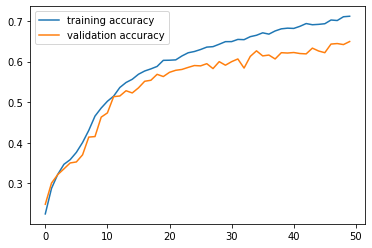

In [94]:
# Plot accuracy values for training and validation sets
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

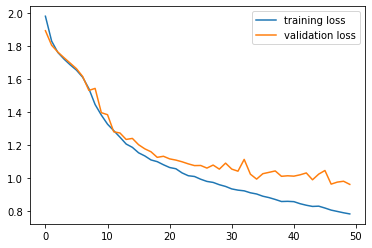

In [93]:
# Plot loss values for training and validation sets
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

After 50 training epochs, an accuracy of approximately 64% is achieved on the validation set. Although this accuracy is lower than the previous model, the behaviour of the training loss and accuracy loss are much more similar, and the validation loss does decrease over the epochs.

# **P2**

The neural network architectures in part 1 are investigated and improved upon to achieve a higher validation accuracy (with at least 85% validation accuracy over 50 epochs). 

# **Rationale:**

Firstly, the training data is augmented to create 'more' data for the model to be trained on. The Mel spectrograms are randomly flipped, cropped, rotated, and their brightness and constrast features are adjusted to create 4 new versions of each original spectrogram.  


The model itself is also adapted to optimise validation accuracy, whilst ensuring validation loss remains minimal and overfitting is avoided. Two additional branches are added to the structure from Part 1.1, and it is decided that these branches will run sequentially (rather than in parallel). The modified model consists of four convolutional blocks which each contain a max pooling layer as before. However, each convolutional layer is batch normalised and then ReLU activation is applied (instead of leaky ReLU). Batch Normalisation is found to be an effective regularisation technique and ReLU is found to produce better results that Leaky ReLU. Dropout layers are also instantiated at the end of each convolutional block as further regularisation.

Each convolutional block has an increasing number of filters in their convolutional layers, which increase as standardly within CNN literature (32-64-128-256), as deeper layers of a CNN tend to learn more complex and abstract features compared to shallower layers. The kernel size remains the same in each block. A pool size of (2,2) is also maintained for each pooling layer in each block (as in P1.2). The dropout level is also increased within each block (0.2-0.3-0.4-0.5), as this yielded the best results. 

RNN features are also incorporated into the model. The output of the fourth convolutional block is flattened and reshaped to allow it to be fed into an LSTM layer. This layer helps to capture any temporal dependencies in the data. The data is then fed to a dense output layer of size 8 that uses softmax activation (as before). 

After investigation using different optimisation algorithms and learning rates, it is found that the model performs best using the Adam optimiser with a learning rate of 0.0005.

Thus, the improved model is compiled and fitted using the augmented, batched training data and the batched validation data that was used in P1.1.

In [97]:
def data_augmentation(data, label):
  # Stores the original and augmented Mel spectrogroms
    images = [data]

    # Flips spectrogram randomly and appends to images
    flipped1 = tf.image.random_flip_left_right(data)
    images.append(flipped1)

    # Adjusts brightness and contrast randomly and appends to images
    flipped2 = tf.image.random_brightness(data, max_delta=0.1)
    flipped2 = tf.image.random_contrast(data, lower=0.9, upper=1.1)
    images.append(flipped1)
    
    # Crops spectrogram randomly (whilst maintaing size (80,80,1)) and appends to images
    padded = tf.image.pad_to_bounding_box(data, offset_height=0, offset_width=0, target_height=100, target_width=100)
    flipped3 = tf.image.random_crop(padded, size=[80, 80, 1])
    images.append(flipped3)

    # Rotates spectrogram randomly by either 90, 180, 270, or 360/0 degrees, and appends to images
    flipped4 = tf.image.rot90(data, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    images.append(flipped4)

    # Stacks all of the spectrograms together into a single tensor
    stack = tf.stack(images, axis=0)

    # Adds relevant genre label to each augmented Mel spectrogram 
    num_aug = stack.shape[0] - 1
    aug_labels = tf.tile(tf.expand_dims(label, axis=0), [num_aug + 1, 1])

    return stack, aug_labels

# Augment the unbatched training set - the process is autotuned to allow for optimal augmentation
augmented_dataset = train_dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

In [100]:
# The dataset is unbatched to 'unlink' each set of spectrograms based on the same image i.e. aug has shape (80,80,1) again
aug = augmented_dataset.unbatch()

In [101]:
# Dataset is then batched again (as in Part 1) to feed in to the mini batch optimisation algorithm
batch_size = 128

aug_batched = aug.batch(batch_size)

<BatchDataset element_spec=(TensorSpec(shape=(None, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [102]:
# Input is initialised
inputs = tf.keras.layers.Input(shape=(80, 80, 1))

# First convolutional block
conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(inputs)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.ReLU()(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)

# Second convolutional block
conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(drop1)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = tf.keras.layers.ReLU()(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
drop2 = tf.keras.layers.Dropout(0.3)(pool2)

# Third convolutional block
conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(drop2)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv3 = tf.keras.layers.ReLU()(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
drop3 = tf.keras.layers.Dropout(0.4)(pool3)

# Fourth convolutional block
conv4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(drop3)
conv4 = tf.keras.layers.BatchNormalization()(conv4)
conv4 = tf.keras.layers.ReLU()(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
drop4 = tf.keras.layers.Dropout(0.5)(pool4)

# RNN component 
flatten = tf.keras.layers.Flatten()(drop4)
reshape = tf.keras.layers.Reshape((5, -1))(flatten)
lstm = tf.keras.layers.LSTM(units=64)(reshape)

# Output layer
output = tf.keras.layers.Dense(8, activation='softmax')(lstm)

# Create model
model = tf.keras.Model(inputs=inputs, outputs=output)


# Optimizer defined - Adam optimizer with learning rate of 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

no_epochs = 50
history = model.fit(aug_batched, epochs=no_epochs, validation_data=val_dataset_batch)

Epoch 1/50
375/375 [==============================] - 30s 68ms/step - loss: 1.4161 - accuracy: 0.4725 - val_loss: 2.5674 - val_accuracy: 0.2404
Epoch 2/50
375/375 [==============================] - 27s 72ms/step - loss: 1.1274 - accuracy: 0.5873 - val_loss: 1.1713 - val_accuracy: 0.5650
Epoch 3/50
375/375 [==============================] - 26s 69ms/step - loss: 1.0000 - accuracy: 0.6370 - val_loss: 0.8279 - val_accuracy: 0.6992
Epoch 4/50
375/375 [==============================] - 25s 66ms/step - loss: 0.9098 - accuracy: 0.6724 - val_loss: 0.8353 - val_accuracy: 0.6921
Epoch 5/50
375/375 [==============================] - 25s 66ms/step - loss: 0.8401 - accuracy: 0.6985 - val_loss: 0.7405 - val_accuracy: 0.7321
Epoch 6/50
375/375 [==============================] - 25s 65ms/step - loss: 0.7896 - accuracy: 0.7192 - val_loss: 0.6795 - val_accuracy: 0.7558
Epoch 7/50
375/375 [==============================] - 24s 65ms/step - loss: 0.7404 - accuracy: 0.7362 - val_loss: 0.6554 - val_accuracy:

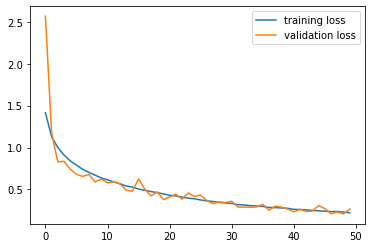

In [103]:
# Plot loss values for training and validation sets
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

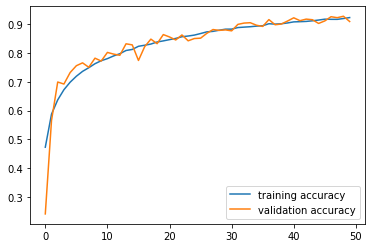

In [104]:
# Plot accuracy values for training and validation sets
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

This refined model that is trained on an augmented dataset shows a clear improvement in classification predictions, with a validation accuracy of approximately 91-93%, compared to accuracies of approximately 71% and 64% in the models in part 1.

The loss and accuracy plots also show a much steadier convergence of validation loss and validation accuracy compared to P1.1. Additionally, the training and validation accuracies (and losses) converge much more closely together in this case.